In [1]:
import numpy as np
import polytope as pc
from itertools import combinations
from collections import OrderedDict

import matplotlib.pyplot as plt
from matplotlib import patches

import sys
sys.path.append('../')

from best.abstraction import LTIAbstraction
from best.mdp import MDP, ProductMDP, ParallelMDP
from best.ltl import solve_ltl_cosafe

from Models.Linear import LTI

# Define the linear time invariant system
#A = np.array([[0,-0.8572],[0.1,0.5]])
dim = 2
A = np.eye(2) #np.array([[.9,-0.32],[0.1,0.9]])
B = np.eye(dim)  #array([[1], [0.1]])
W = np.array([[0,0],[0,0.4]]) #2*Tr.dot(np.eye(dim)).dot(Tr)  # noise on transitions
 
# Accuracy
C = np.array([[1, 0],[0,1]])  # defines metric for error (||y_finite-y||< epsilon with y= cx   )

sys_lti = LTI(A, B, C, None, W=W)  # LTI system with   D = None
sys_lti.setU(pc.box2poly(np.kron(np.ones((sys_lti.m, 1)), np.array([[-1, 1]])))) # continuous set of inputs
sys_lti.setX(pc.box2poly(np.kron(np.ones((sys_lti.dim, 1)), np.array([[-10, 10]])))) # X space

# How far away do we detect labels
sight_distance = 2

In [2]:
# Define regions of interest for the labeling
regions = OrderedDict()
regions['target1'] = pc.box2poly(np.array([[-9, -6], [6, 9]]))
regions['target2'] = pc.box2poly(np.array([[6, 9], [6, 9]]))
regions['obstacle1'] = pc.box2poly(np.array([[0, 2], [-5, 2]]))
regions['obstacle2'] = pc.box2poly(np.array([[0, 2], [3, 10]]))

def close(poly, point, distance):
    # returns true if point within distance of poly
    return np.all(poly.A.dot(point.flatten()) < poly.b + distance)

In [3]:
## step 1: tune gridding ratio (find optimal horizontal d_1, and vertical d_2)
# currently only available for 2D
# d_opt, d_vals, eps_values = tune_dratio(sys_n)

d_opt = np.array([[ 0.69294],
                  [ 0.721  ]])

# d = np.array([[1.5], [1.5]])
d = d_opt

### Construct map MDP

In [4]:
def target_output(n):
    if n == 0:
        return 'init'     # label unknown
    if n == 1:
        return 'true'     # label true
    if n == 2:
        return 'false'    # label false

# label prior probabilities
p_list = [0.5, 0.6, 0.1, 0.3]

mdp_list = [MDP([np.eye(3), np.array([[0,p,1-p], [0,1,0], [0,0,1]])], 
                input_name='meas{}'.format(i),
                output_fcn=target_output,
                output_name='label{}'.format(i))
            for (i, p) in enumerate(p_list)]

map_mdp = ParallelMDP(mdp_list)
print map_mdp

MDP: 16 inputs "(meas0, meas1, meas2, meas3)" --> 81 outputs "(label0, label1, label2, label3)"


### Construct abstraction

Warning no inputspace given
Warning no state space given
status: optimal
optimal epsilon 1.00000639831
optimal M [[ 1.  0.]
 [ 0.  1.]]
Optimal K [[ 0. -1.]
 [-1.  0.]]
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
('check norm of rows', matrix([[ 0.,  1.],
        [-1.,  0.],
        [ 0., -1.],
        [ 1.,  0.]]))
MDP: 9 inputs "u_d" --> 871 outputs "(s, x_d)"
nnz: 176532, sparsity: 0.0258550047607


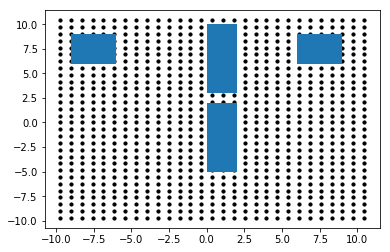

In [5]:
# mdp_grid = sys_n.abstract_io(d, un=4, verbose=False)  # do the gridding
# mdp_grid.map_dfa_inputs(dict_input2prop, regions)

abstr = LTIAbstraction(sys_lti, d, un=3)
abstr.set_regions(regions)

in_regions, nin_regions = abstr.map_dfa_inputs()

fig = plt.figure()
ax0 = fig.add_subplot(111)
abstr.plot(ax0)

# plot regions
for poly in regions.itervalues():
    V = pc.extreme(poly)
    ax0.add_patch(patches.Polygon(V))

print abstr.mdp
print 'nnz: {}, sparsity: {}'.format(abstr.mdp.nnz(), abstr.mdp.sparsity())

### Connect abstraction and map

In [6]:
# mapping (s, x_d) -> 2^2^(meas1, meas2, meas3)
def map_connection(s_xd):
    if s_xd[0] == abstr.mdp.N-1:
        return set([(0,0,0,0)])
    
    x_d = np.array(s_xd[1]).reshape((2,1))
        
    mapstate = [0 for i in range(len(regions))]
    for i, poly in enumerate(regions.values()):
        if close(poly, x_d, sight_distance):
            mapstate[i] = 1
    return set([tuple(mapstate)])

prod_mdp = abstr.mdp.product(map_mdp, map_connection)
print prod_mdp

MDP: 9 inputs "u_d" --> 70551 outputs "((s, x_d), (label0, label1, label2, label3))"


### Set up LTL problem

In [7]:
from best import subsets

formula = '( F sample ) & ( ! obstacle U sample )'

def get_regions(s):
    '''compute subsets of possible regions corresponding to abstract state'''   
    if s == abstr.mdp.N-1:
        return set([ (), ])
    
    know_in = []
    know_out = []
    for reg in regions.keys():
        if in_regions[reg][s] == 0:
            know_out.append(reg)
        if nin_regions[reg][s] == 0:
            know_in.append(reg)
    uncertain = list(set(regions.keys()) - set(know_in) - set(know_out))
    return set([ tuple(know_in + unc) for unc in subsets(uncertain)])  

# map ((s, xd), (label1, label2, label3)) -> 2^2^{sample, obstacle}
def abstract_connection(s_xd_lbls):
    s = s_xd_lbls[0][0]
    current_regs = get_regions(s)
    
    lbl_t1  = s_xd_lbls[1][0]
    lbl_t2  = s_xd_lbls[1][1]
    lbl_ob1 = s_xd_lbls[1][2]
    lbl_ob2 = s_xd_lbls[1][3]

    ret = []
    
    if all('target1' in reg for reg in current_regs) and lbl_t1 == 'true' or \
       all('target2' in reg for reg in current_regs) and lbl_t2 == 'true':
        # we are in target region and a sample exists
        ret.append('sample')
        
    if any('obstacle1' in reg for reg in current_regs) and lbl_ob1 == 'true' or \
       any('obstacle2' in reg for reg in current_regs) and lbl_ob2 == 'true':
        # we are in obstacle region and there is an obstacle
        ret.append('obstacle')
        
    return set([tuple(ret)])


obs_state = abstr.closest_abstract(np.array([[2],[0]]))
print 'obstacle: ', abstract_connection( ( (obs_state, (_, _)), ('init', 'init', 'true', 'init') ) )
print 'no obstacle: ',abstract_connection( ( (obs_state, (_, _)), ('init', 'init', 'false', 'init') ) )

target_state = abstr.closest_abstract(np.array([[7.5],[7.5]]))

print 'sample: ', abstract_connection( ( (target_state, (_, _)), ('init', 'true', 'init', 'init') ) )
print 'no sample: ', abstract_connection( ( (target_state, (_, _)), ('init', 'init', 'init', 'init') ) )


obstacle:  set([('obstacle',)])
no obstacle:  set([()])
sample:  set([('sample',)])
no sample:  set([()])


### Solve recursion

In [8]:
pol = solve_ltl_cosafe(prod_mdp, formula, abstract_connection, algorithm='petter')

iteration 0, time 0.000341176986694
iteration 1, time 1.6556429863
iteration 2, time 3.26583600044
iteration 3, time 4.88960814476
iteration 4, time 6.47667813301
iteration 5, time 8.0818901062
iteration 6, time 9.73331999779
iteration 7, time 11.3186910152
iteration 8, time 12.9149651527
iteration 9, time 14.5428071022
iteration 10, time 16.1472129822
iteration 11, time 17.7427411079
iteration 12, time 19.2951071262
iteration 13, time 20.8330910206
iteration 14, time 22.4485721588
iteration 15, time 24.0216159821
iteration 16, time 25.5859651566
iteration 17, time 27.1326811314
iteration 18, time 28.7281341553
iteration 19, time 30.304336071
iteration 20, time 31.9081091881
iteration 21, time 33.4933431149
iteration 22, time 35.0797691345
iteration 23, time 36.6287469864
iteration 24, time 38.184248209
iteration 25, time 39.7222621441
iteration 26, time 41.3202831745
iteration 27, time 42.8878421783
iteration 28, time 44.4593000412
iteration 29, time 46.0306861401
iteration 30, time 4

### Define policy

In [9]:
# define a policy on top of mdp policy
def my_policy(x, mapstate):
    # x: current concrete state [x; y]
    x = np.array(x).reshape((2,1))
    
    lbl_t1 = mapstate[0]
    lbl_t2 = mapstate[1]
    lbl_ob1 = mapstate[2]
    lbl_ob2 = mapstate[3]

    aps = []
    
    if regions['target1'].contains(x) and lbl_t1 == 1 or \
       regions['target2'].contains(x) and lbl_t2 == 1:
        # we are in target region and a sample exists
        aps.append('sample')
        
    if regions['obstacle1'].contains(x) and lbl_ob1 == 1 or \
       regions['obstacle2'].contains(x) and lbl_ob2 == 1:
        # we are in obstacle region and not sure that there is no obstacle
        aps.append('obstacle')
        
    pol.report_aps(aps)
    
    s_abstract = abstr.closest_abstract(x)
    
    s_tot = prod_mdp.global_state((s_abstract, mapstate ))
   
    u_abstract, curr_val = pol.get_input(s_tot)
    
    if curr_val > 0 and u_abstract != -1:
        return abstr.refine_input(u_abstract, s_abstract, x)
    else:
        return np.array([[0], [0]])

def my_value(x):    
    x = np.array(x).reshape((2,1))
    
    s_abstract = abstr.closest_abstract(x)
    s_tot = prod_mdp.global_state( (s_abstract, (0,0,0,0)) )

    _, val = pol.get_input(s_tot)
    return val

def my_policy_init(x):
    u = my_policy(x, (0,0,0,0))
    pol.reset()
    return u

pol.reset()

### Plot value function

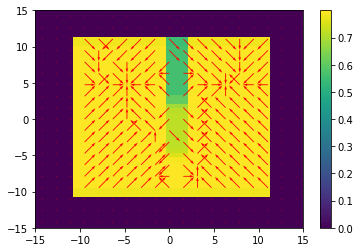

In [10]:
fig = plt.figure()
x_edge = np.linspace(-15,15,50)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,50)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

values = np.array([my_value((x,y)) for (x,y) in zip(xi, yi)])

plt.pcolor(x_edge, y_edge, values.reshape((49,49)))
plt.colorbar()
plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

x_edge = np.linspace(-15,15,20)
x_del = np.diff(x_edge).max()
y_edge = np.linspace(-15,15,20)
y_del = np.diff(y_edge).max()

xi, yi = np.meshgrid(x_edge[:-1]+x_del/2,y_edge[:-1]+y_del/2)
xi = xi.flatten()
yi = yi.flatten()

delx_fun = lambda x,y: sys_lti.a.dot(np.array([[x], [y]])) + sys_lti.b.dot(my_policy_init((x,y))) - np.array([[x], [y]])

delx = np.hstack([delx_fun(x,y) for (x,y) in zip(xi, yi)])

x_tr = (np.block([[xi.flatten()], [yi.flatten()]]))

plt.quiver(xi, yi, delx[0], delx[1], color = 'r')


### Run a simulation

Matrix is singular and may not have a square root.
reached
reached
not reached
reached
reached
reached


Text(0,0.5,u'x_2')

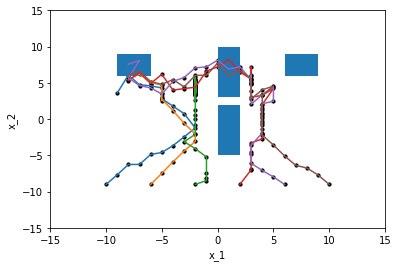

In [11]:
import scipy.linalg as scla
import matplotlib

np.random.seed(4)

time = 70
fig = plt.figure()
ax = fig.add_subplot(111)

# plot regions
for poly in regions.itervalues():
    V = pc.extreme(poly)
    ax.add_patch(matplotlib.patches.Polygon(V))
    
realmap = [1, 2, 1, 2]   # true map state

Wsqrt = scla.sqrtm(sys_lti.W)
for xinit in range(-10, 11, 4):
    pol.reset()
    mapstate = [0, 0, 0, 0]
    xx = np.array([[xinit],[-9]])

    for t in range(time): 
        # current state
        xt = xx[:,-1].reshape(2,1)
        # reveal map if within distance
        for i, poly in enumerate(regions.itervalues()):
            if close(poly, xt, sight_distance):
                mapstate[i] = realmap[i]
        # next state
        ut = my_policy(xt, mapstate)
        wt = np.random.normal(0,1,size=(2,1))
        # update state
        xt1 = sys_lti.a.dot(xt)+sys_lti.b.dot(ut) + np.array(Wsqrt).dot(wt)

        xx = np.hstack([xx, xt1])

        if pol.finished() :
            print('reached')
            break

    if not pol.finished():
        print('not reached')

    plt.plot(xx[0,:],xx[1,:])
    plt.scatter(xx[0,:],xx[1,:], label='Finite states', color='k', s=10, marker="o")

plt.xlim(np.array([-15,15]))
plt.ylim(np.array([-15,15]))

plt.xlabel('x_1') 
plt.ylabel('x_2') 
